# Payload Flight Data Logger and Plotter

This notebook processes flight log data and generates visualizations for altitude, attitude (yaw/pitch/roll), and acceleration measurements.

## Setup and Library Installation

Install required libraries and import necessary packages for data processing and visualization.

In [62]:
# Install required packages
import subprocess
import sys

packages = ['aquarel', 'matplotlib', 'pandas']
for package in packages:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', package])

print("All packages installed successfully")

All packages installed successfully


## Import Libraries and Configure Theme

Import necessary libraries and apply the aquarel umbra light theme for consistent plot styling.

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import aquarel
import os
from pathlib import Path

# Apply aquarel umbra light theme
aquarel.load_theme("umbra_dark").apply()

# Create plots directory if it doesn't exist
Path("plots").mkdir(exist_ok=True)

print("Libraries imported and theme applied")

Libraries imported and theme applied


## Load and Parse Flight Data

Read the flight log file and split it into separate flights based on the `[---END OF FLIGHT---]` delimiter.

In [64]:
# Cell: Load and Parse Flight Data
def load_flight_data(filepath):
    """
    Load flight data from a txt file and split into separate flights.
    Returns a list of DataFrames, one for each flight.
    """
    flights = []
    current_flight = []
    
    with open(filepath, 'r') as f:
        lines = f.readlines()
    
    # Skip header and parse data
    header_line = None
    for i, line in enumerate(lines):
        line = line.strip()
        
        # Store header
        if 'millis' in line and header_line is None:
            header_line = line
            continue
        
        # Check for end of flight marker
        if '[---END OF FLIGHT---]' in line:
            if current_flight:
                # Convert to DataFrame
                from io import StringIO
                data_str = header_line + '\n' + '\n'.join(current_flight)
                df = pd.read_csv(StringIO(data_str))
                flights.append(df)
                current_flight = []
            continue
        
        # Add data line to current flight
        if line and not line.startswith('['):
            current_flight.append(line)
    
    # Handle last flight if no end marker
    if current_flight:
        from io import StringIO
        data_str = header_line + '\n' + '\n'.join(current_flight)
        df = pd.read_csv(StringIO(data_str))
        flights.append(df)
    
    return flights

# Load the flight data
log_file = "flight_log_11_20_25.txt"
flights = load_flight_data(f"data/{log_file}")

filename = Path(log_file).stem  # Removes .txt extension

# Create directory structure for this log file
base_plot_dir = Path("plots") / filename
base_plot_dir.mkdir(parents=True, exist_ok=True)

print(f"Loaded {len(flights)} flight(s) from {log_file}")
for i, flight in enumerate(flights, 1):
    print(f"  Flight {i}: {len(flight)} data points")

Loaded 3 flight(s) from flight_log_11_20_25.txt
  Flight 1: 29174 data points
  Flight 2: 74741 data points
  Flight 3: 57823 data points


## Plot 1: Altitude vs Time

Plot altitude over time with background shading based on flight state (GROUND, ASCENT, DESCENT, LANDED).

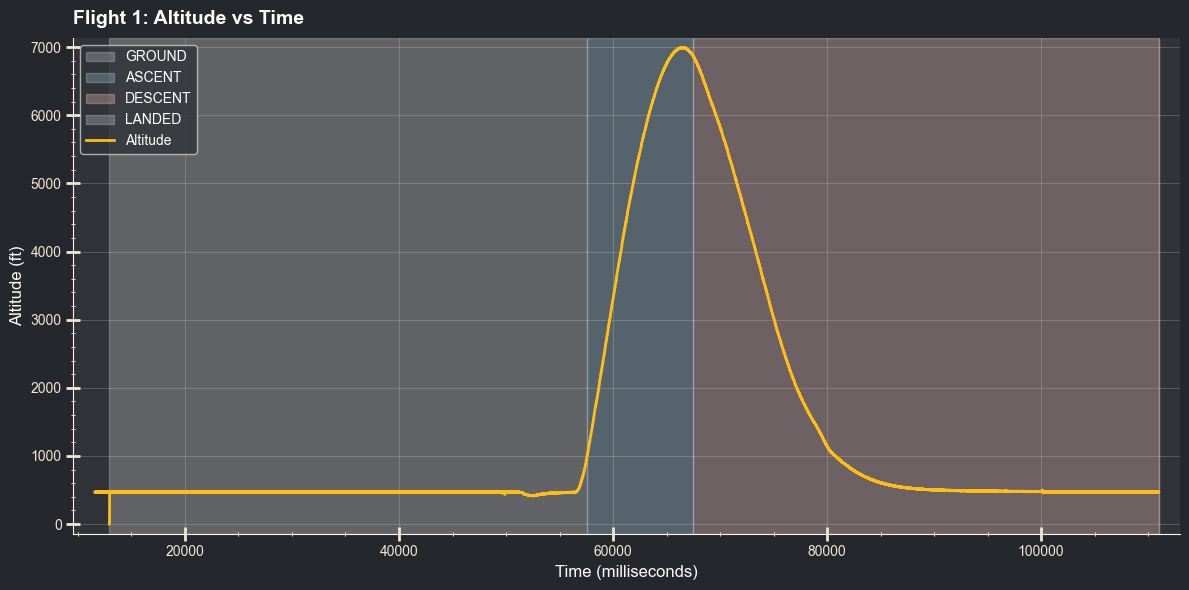

Saved: plots/flight_log_11_20_25/flight1/flight_log_11_20_25_altitude_f1.png


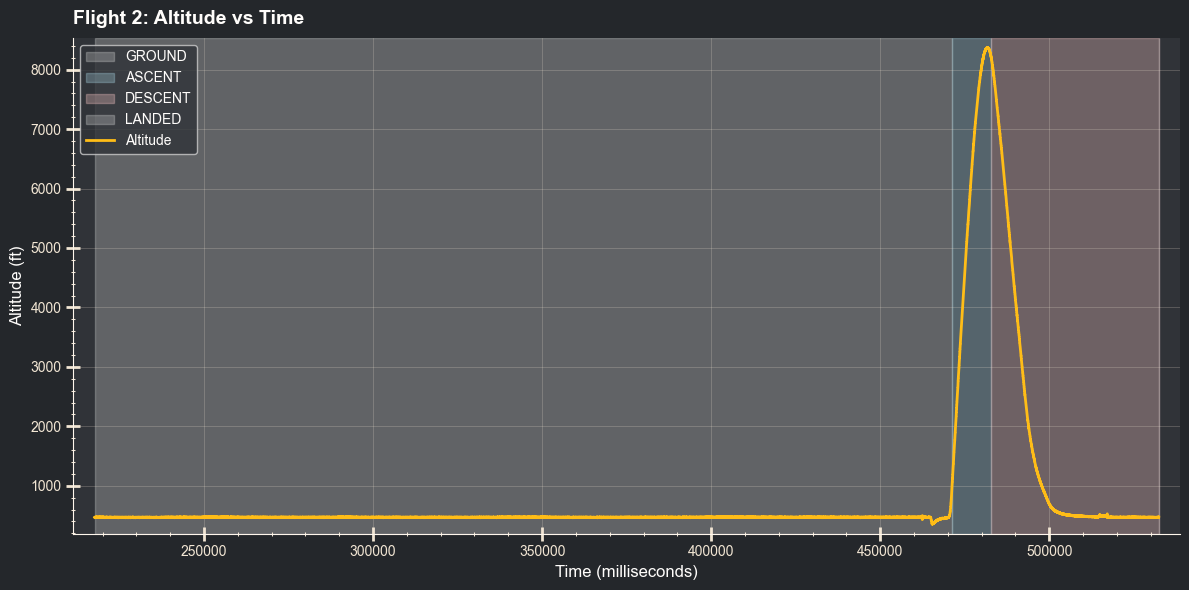

Saved: plots/flight_log_11_20_25/flight2/flight_log_11_20_25_altitude_f2.png


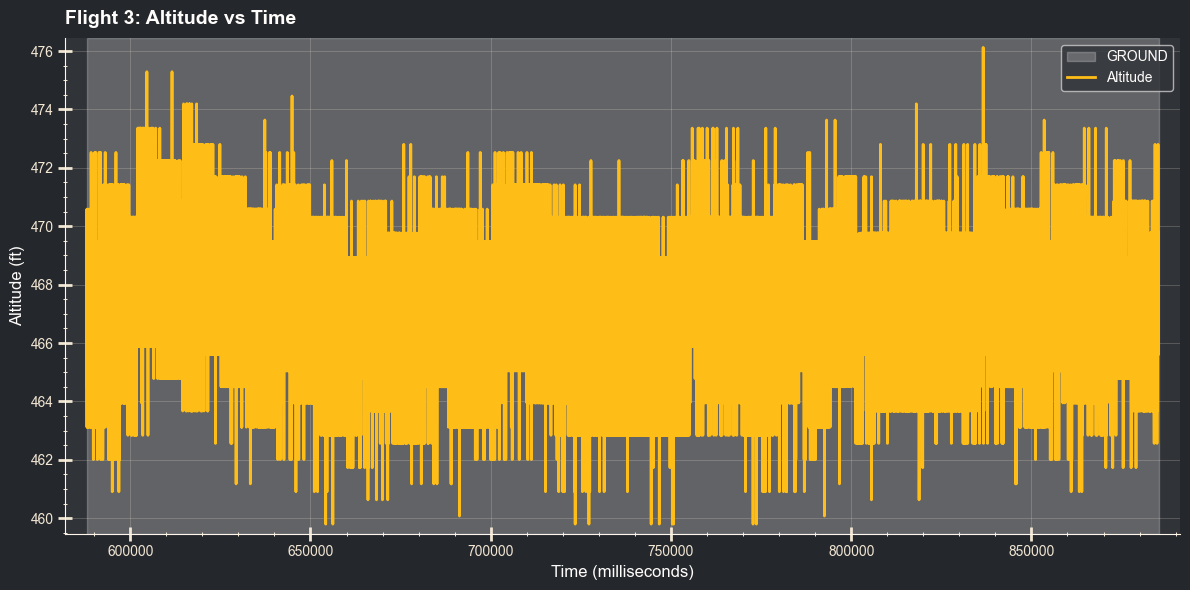

Saved: plots/flight_log_11_20_25/flight3/flight_log_11_20_25_altitude_f3.png


In [65]:
# Cell: Plot 1: Altitude vs Time
def plot_altitude(df, flight_num, filename):
    """Plot altitude vs time with state-based background shading."""
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Define state colors (light shading)
    state_colors = {
        'GROUND': '#d3d3d3',
        'ASCENT': '#add8e6',
        'DESCENT': '#ffcccb',
        'LANDED': '#d3d3d3'
    }
    
    # Add background shading for states
    current_state = None
    start_idx = 0
    
    for idx, row in df.iterrows():
        if row['state'] != current_state:
            # Shade previous state region
            if current_state is not None and current_state in state_colors:
                ax.axvspan(df.loc[start_idx, 'millis'], 
                          df.loc[idx-1, 'millis'],
                          alpha=0.3, 
                          color=state_colors[current_state],
                          label=current_state if current_state not in ax.get_legend_handles_labels()[1] else "")
            current_state = row['state']
            start_idx = idx
    
    # Shade final state region
    if current_state is not None and current_state in state_colors:
        ax.axvspan(df.loc[start_idx, 'millis'], 
                  df.loc[len(df)-1, 'millis'],
                  alpha=0.3, 
                  color=state_colors[current_state],
                  label=current_state if current_state not in ax.get_legend_handles_labels()[1] else "")
    
    # Plot altitude line
    ax.plot(df['millis'], df['altitude_ft'], linewidth=2, color="#FFBD17", label='Altitude')
    
    ax.set_xlabel('Time (milliseconds)', fontsize=12)
    ax.set_ylabel('Altitude (ft)', fontsize=12)
    ax.set_title(f'Flight {flight_num}: Altitude vs Time', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best')
    
    plt.tight_layout()
    
    # Create flight subdirectory and save
    flight_dir = Path("plots") / filename / f"flight{flight_num}"
    flight_dir.mkdir(parents=True, exist_ok=True)
    plt.savefig(flight_dir / f"{filename}_altitude_f{flight_num}.png", dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved: {flight_dir / f"{filename}_altitude_f{flight_num}.png"}")

# Plot altitude for each flight
for i, flight_df in enumerate(flights, 1):
    plot_altitude(flight_df, i, filename)

## Plot 2: Attitude (Yaw, Pitch, Roll) vs Time

Plot yaw, pitch, and roll measurements in three separate subplots within a single frame.

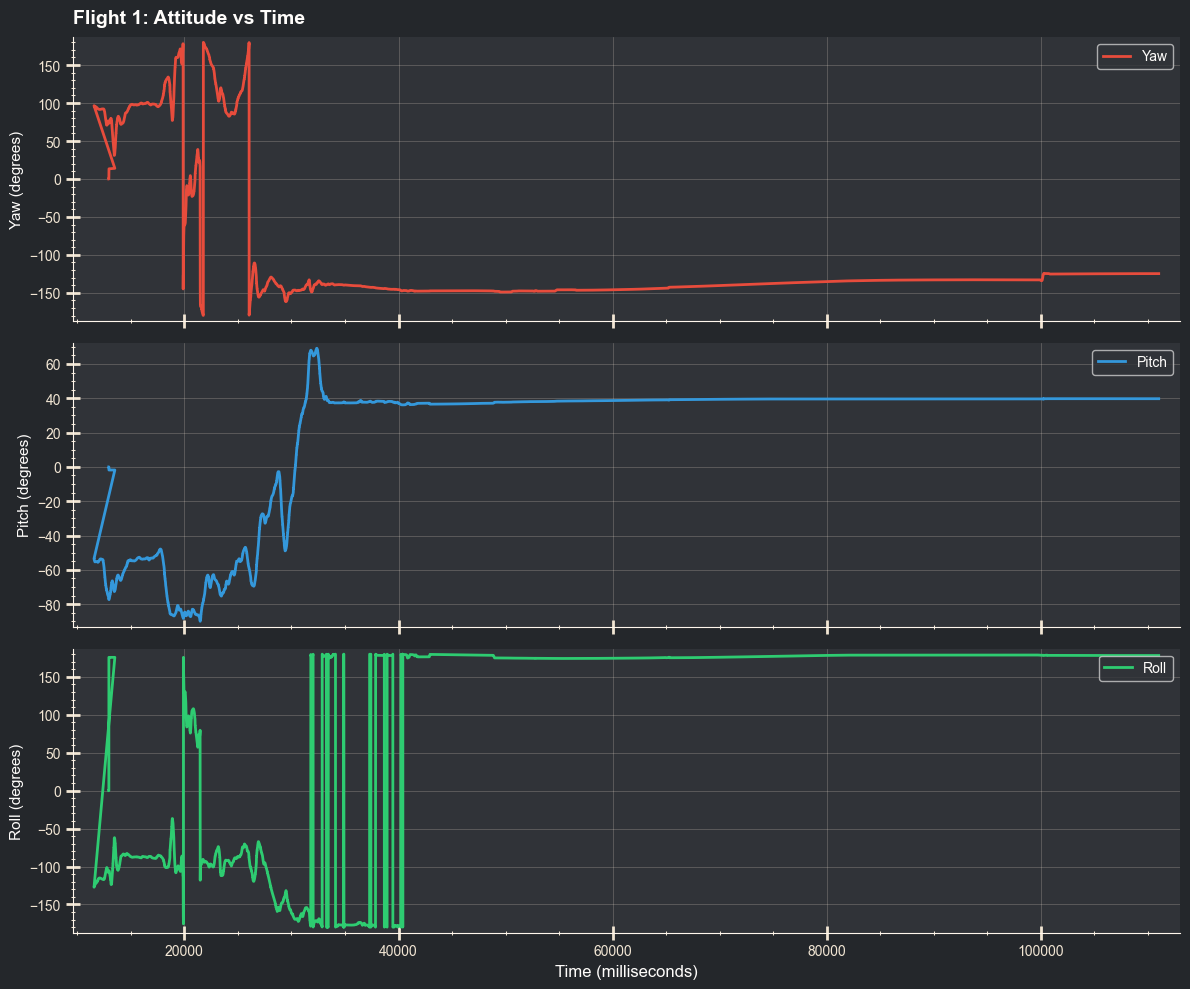

Saved: plots/flight_log_11_20_25/flight1/flight_log_11_20_25_atti_f1.png


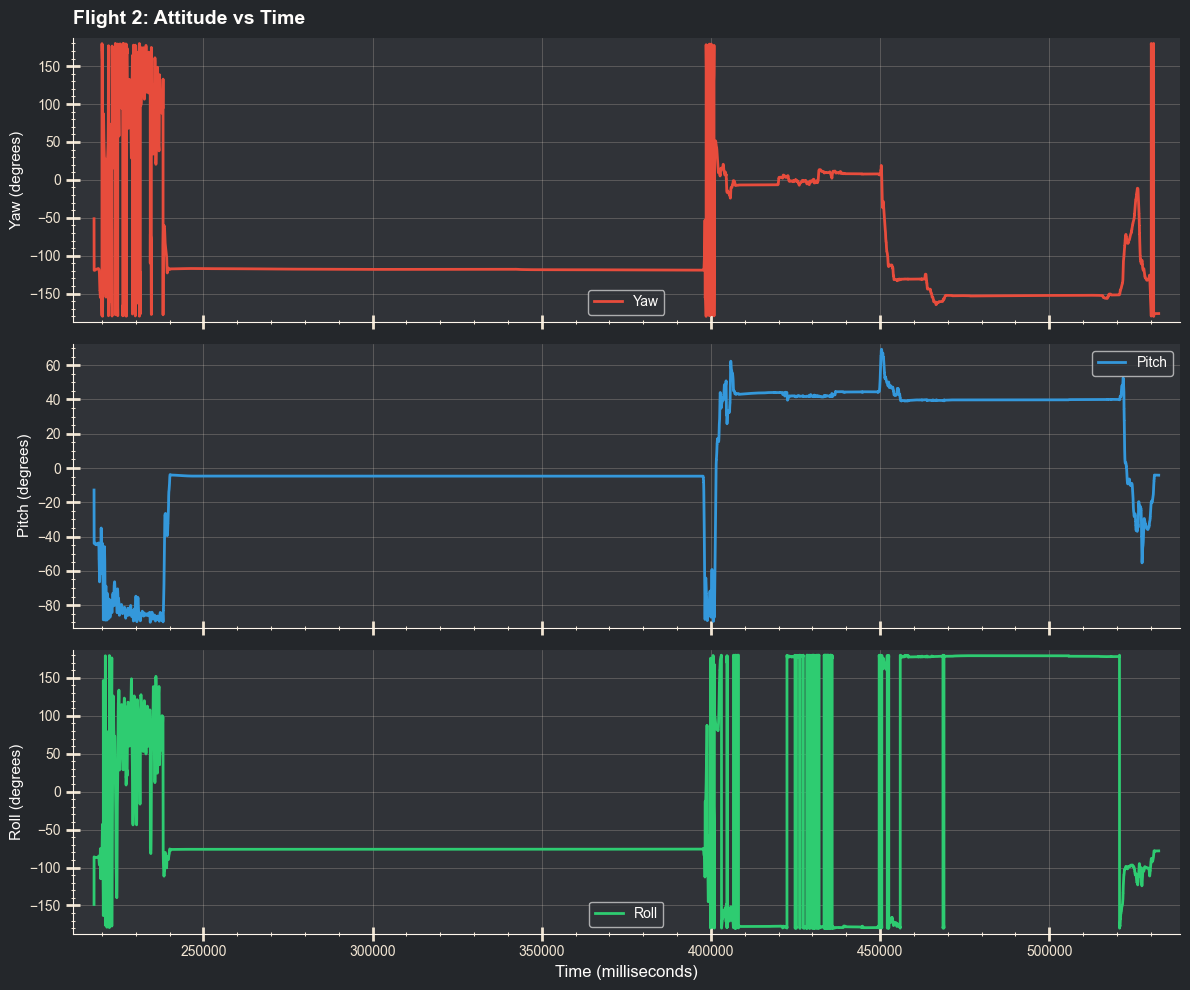

Saved: plots/flight_log_11_20_25/flight2/flight_log_11_20_25_atti_f2.png


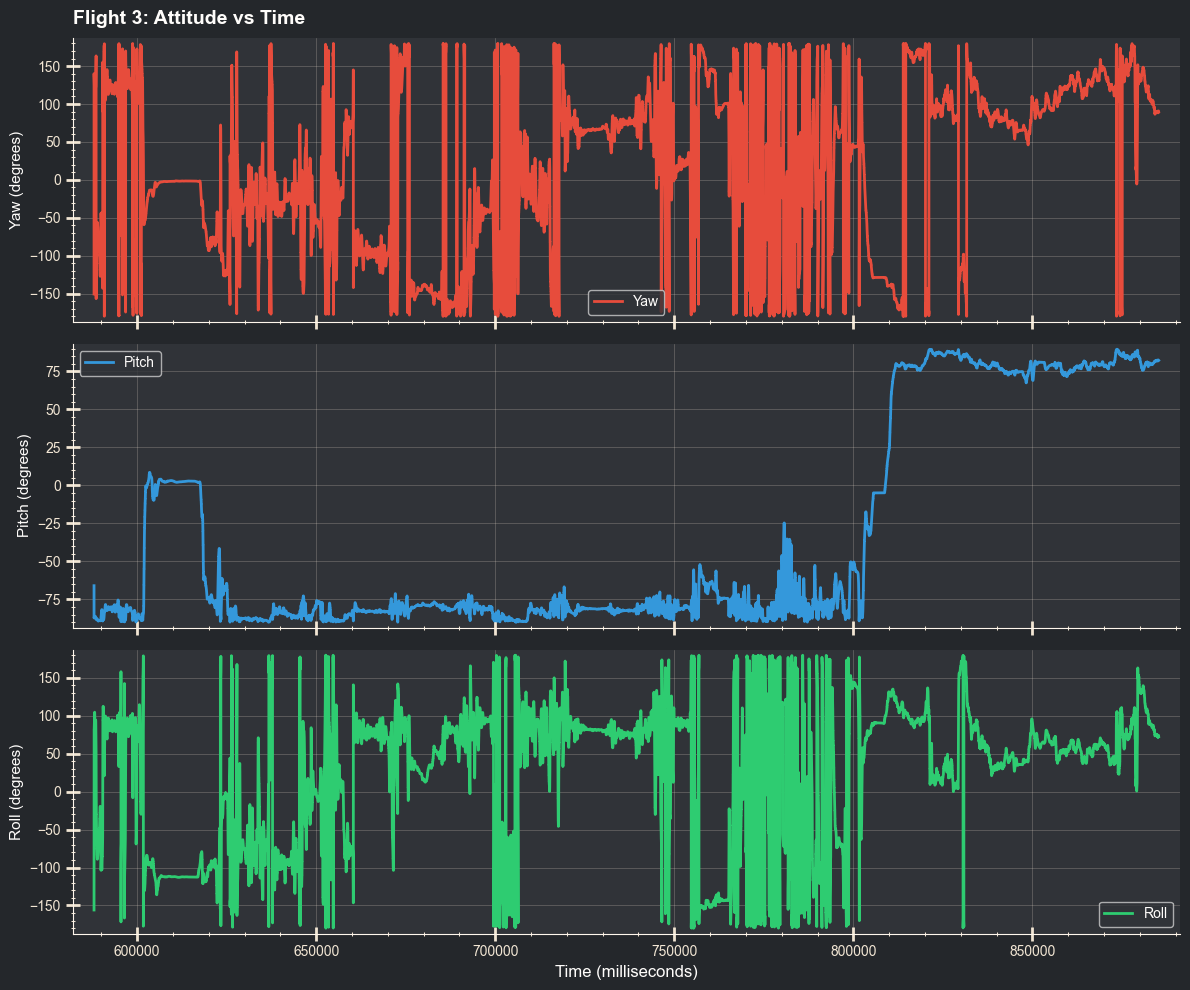

Saved: plots/flight_log_11_20_25/flight3/flight_log_11_20_25_atti_f3.png


In [66]:
# Cell: Plot 2: Attitude (Yaw, Pitch, Roll) vs Time
def plot_attitude(df, flight_num, filename):
    """Plot yaw, pitch, and roll in three subplots."""
    fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
    
    # Yaw subplot
    axes[0].plot(df['millis'], df['yaw_deg'], linewidth=2, color='#e74c3c', label='Yaw')
    axes[0].set_ylabel('Yaw (degrees)', fontsize=11)
    axes[0].set_title(f'Flight {flight_num}: Attitude vs Time', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    axes[0].legend(loc='best')
    
    # Pitch subplot
    axes[1].plot(df['millis'], df['pitch_deg'], linewidth=2, color='#3498db', label='Pitch')
    axes[1].set_ylabel('Pitch (degrees)', fontsize=11)
    axes[1].grid(True, alpha=0.3)
    axes[1].legend(loc='best')
    
    # Roll subplot
    axes[2].plot(df['millis'], df['roll_deg'], linewidth=2, color='#2ecc71', label='Roll')
    axes[2].set_ylabel('Roll (degrees)', fontsize=11)
    axes[2].set_xlabel('Time (milliseconds)', fontsize=12)
    axes[2].grid(True, alpha=0.3)
    axes[2].legend(loc='best')
    
    plt.tight_layout()
    
    # Create flight subdirectory and save
    flight_dir = Path("plots") / filename / f"flight{flight_num}"
    flight_dir.mkdir(parents=True, exist_ok=True)
    plt.savefig(flight_dir / f"{filename}_atti_f{flight_num}.png", dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved: {flight_dir / f"{filename}_atti_f{flight_num}.png"}")

# Plot attitude for each flight
for i, flight_df in enumerate(flights, 1):
    plot_attitude(flight_df, i, filename)

## Plot 3: Acceleration (ax, ay, az) vs Time

Plot x, y, and z acceleration measurements in three separate subplots within a single frame.

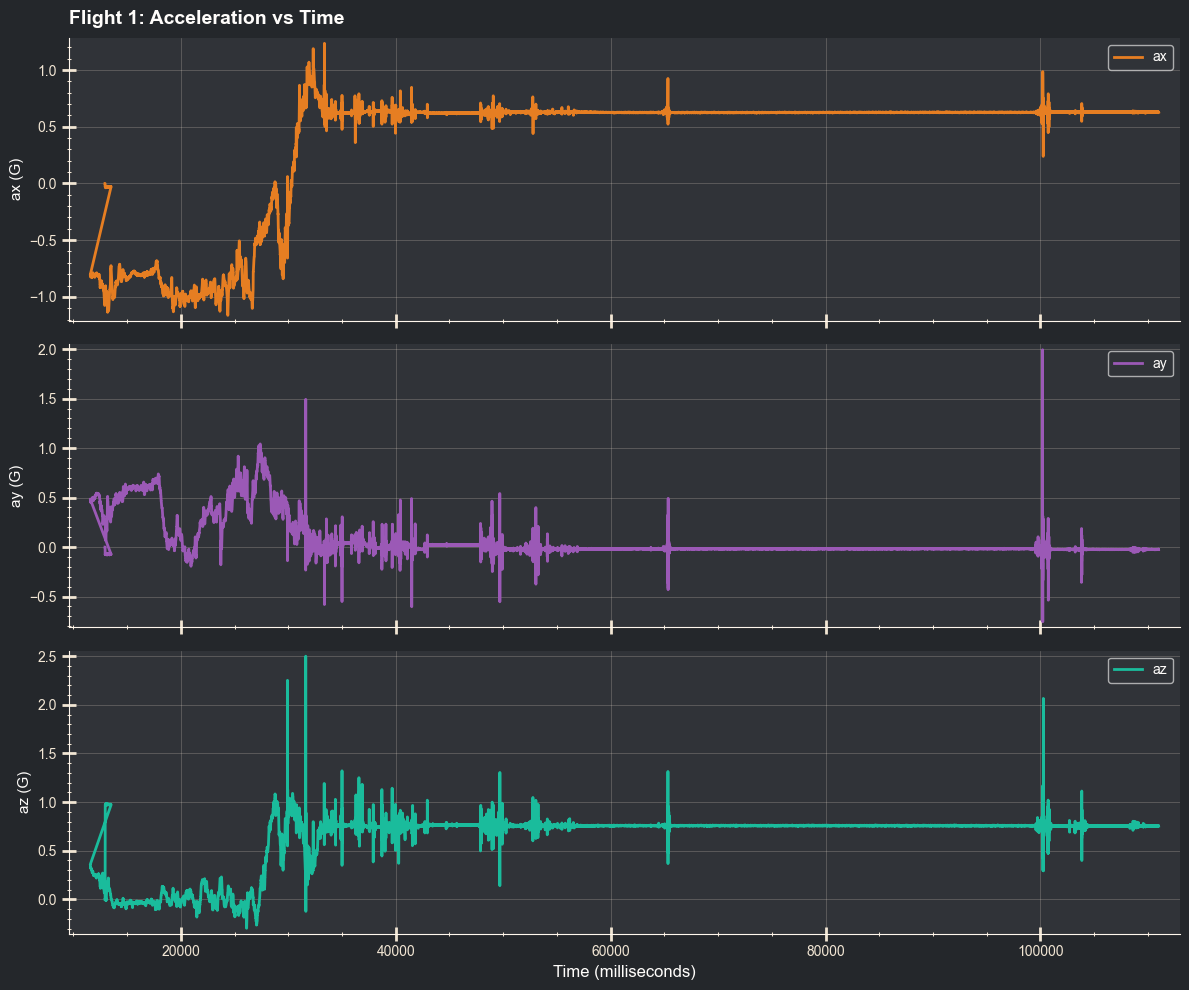

Saved: plots/flight_log_11_20_25/flight1/flight_log_11_20_25_accel_f1.png


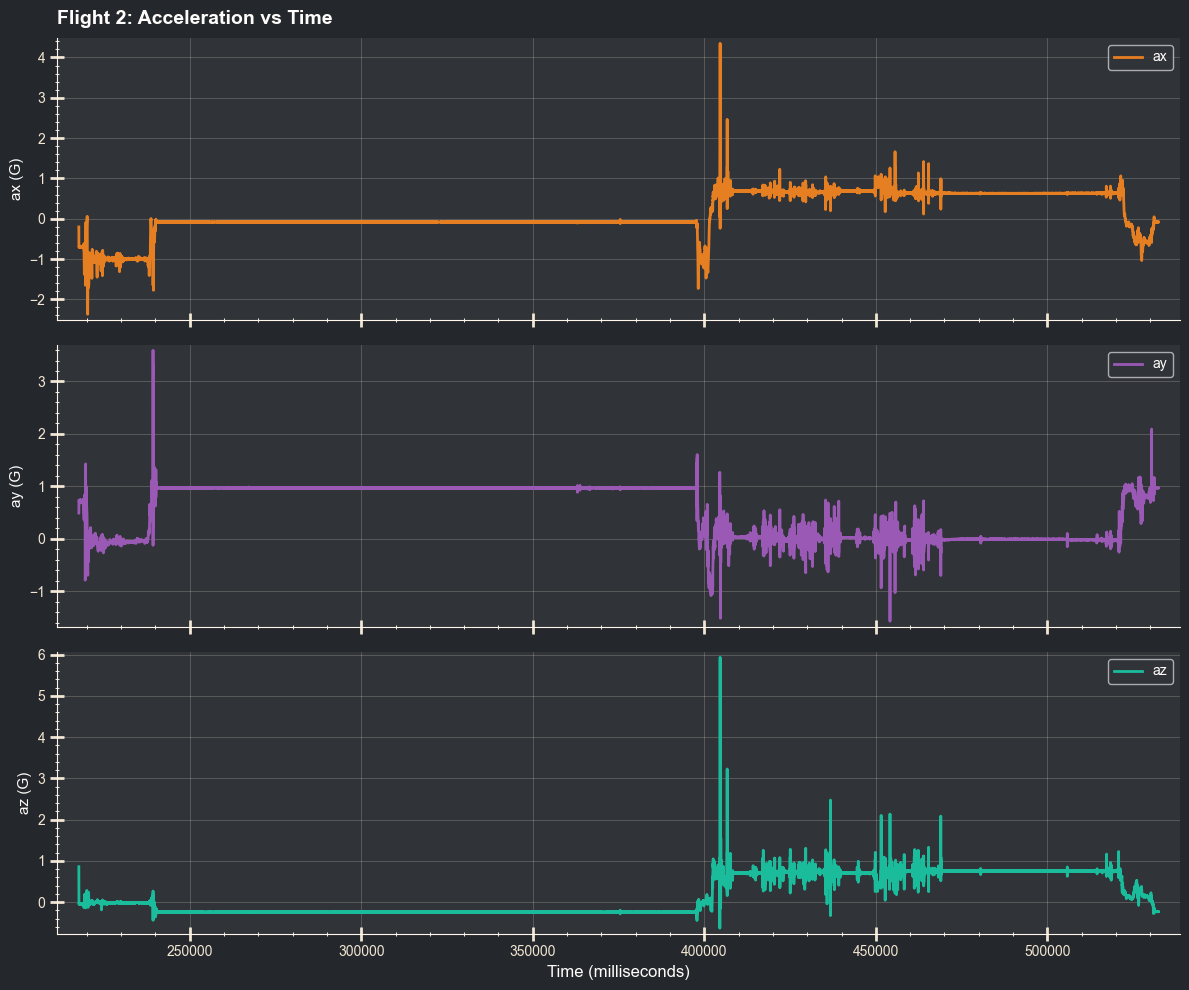

Saved: plots/flight_log_11_20_25/flight2/flight_log_11_20_25_accel_f2.png


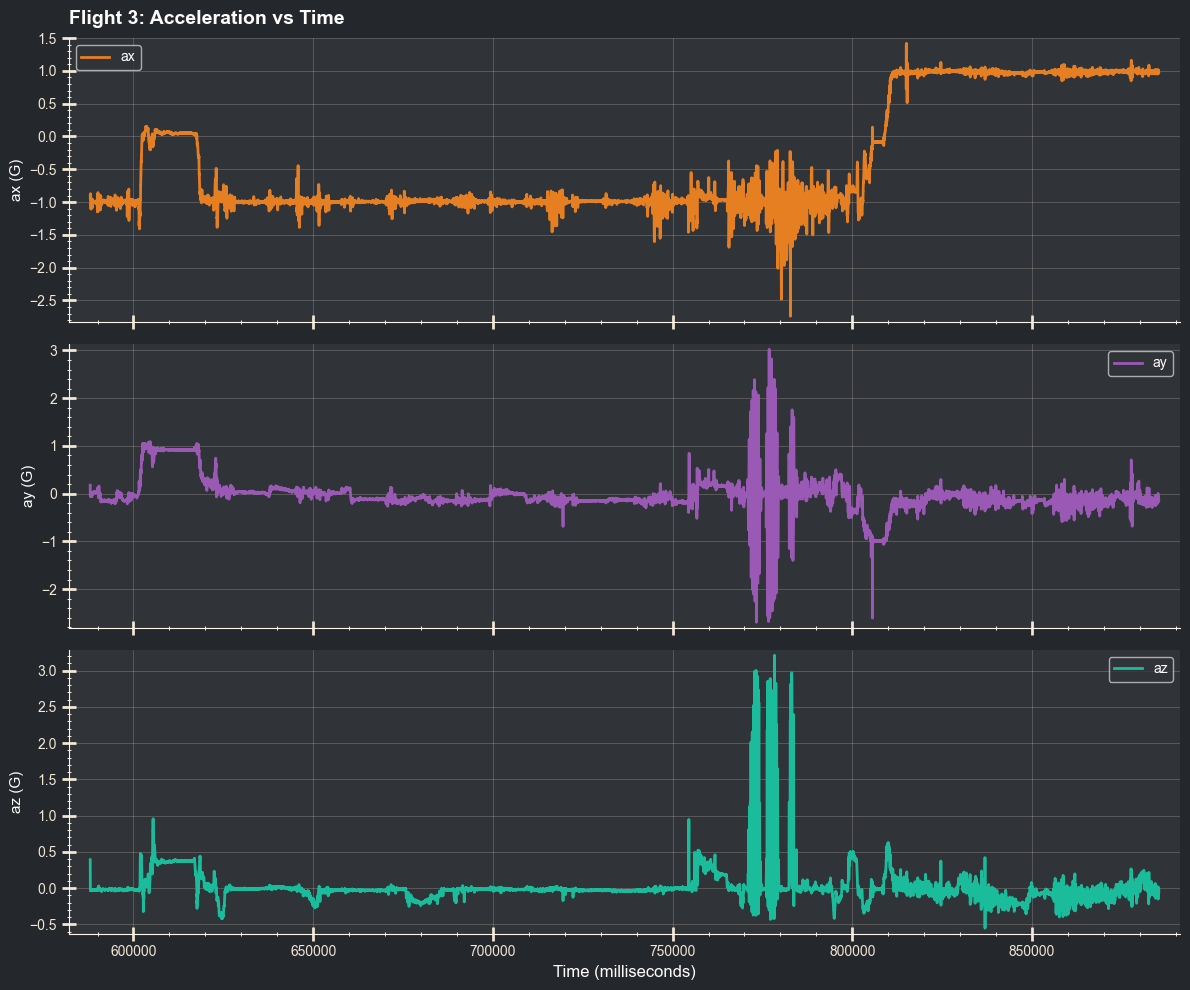

Saved: plots/flight_log_11_20_25/flight3/flight_log_11_20_25_accel_f3.png


In [67]:
# Cell: Plot 3: Acceleration (ax, ay, az) vs Time
def plot_acceleration(df, flight_num, filename):
    """Plot ax, ay, and az in three subplots."""
    fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
    
    # ax subplot
    axes[0].plot(df['millis'], df['ax_G'], linewidth=2, color='#e67e22', label='ax')
    axes[0].set_ylabel('ax (G)', fontsize=11)
    axes[0].set_title(f'Flight {flight_num}: Acceleration vs Time', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    axes[0].legend(loc='best')
    
    # ay subplot
    axes[1].plot(df['millis'], df['ay_G'], linewidth=2, color='#9b59b6', label='ay')
    axes[1].set_ylabel('ay (G)', fontsize=11)
    axes[1].grid(True, alpha=0.3)
    axes[1].legend(loc='best')
    
    # az subplot
    axes[2].plot(df['millis'], df['az_G'], linewidth=2, color='#1abc9c', label='az')
    axes[2].set_ylabel('az (G)', fontsize=11)
    axes[2].set_xlabel('Time (milliseconds)', fontsize=12)
    axes[2].grid(True, alpha=0.3)
    axes[2].legend(loc='best')
    
    plt.tight_layout()
    
    # Create flight subdirectory and save
    flight_dir = Path("plots") / filename / f"flight{flight_num}"
    flight_dir.mkdir(parents=True, exist_ok=True)
    plt.savefig(flight_dir / f"{filename}_accel_f{flight_num}.png", dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved: {flight_dir / f"{filename}_accel_f{flight_num}.png"}")

# Plot acceleration for each flight
for i, flight_df in enumerate(flights, 1):
    plot_acceleration(flight_df, i, filename)

### Summary of Notebook

All plots have been generated and saved to the `plots/` directory. Each flight log is processed separately with three plots: altitude, attitude (yaw/pitch/roll), and acceleration (ax/ay/az).